In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv
import pandas as pd

define lists

In [7]:
# lists for pulseheights and energies of CS (normal data, fits, errors)
pulseheights_CS = [21.8, 59, 70]
energy_CS = [0.04615, 0.5461, 0.6612]
E_fit_CS = []
P_fit_CS = []
E_err_CS = []
P_err = 0.5
P_err_list_CS = []

In [8]:
# lists for pulseheights and energies of NA (normal data, fits, errors)
pulseheights_NA = [54.5, 131.5]
energy_NA = [0.511, 1.274]
E_fit_NA = []
P_fit_NA = []
E_err_NA = []
P_err_list_NA = []

fit for calibration

In [9]:
# define linear function and error calculator
def convert(x, A, B):
    return A*x + B

def error(a, p, c, a_err, p_err, c_err):
  return ((p * a_err) **2 + (a * p_err) **2 + c_err ** 2) ** 0.5

In [10]:
constants_CS = curve_fit(convert, pulseheights_CS, energy_CS, p0 = [0.01, -0.05])
constants_NA = curve_fit(convert, pulseheights_NA, energy_NA, p0 = [0.01, -0.05])

C:\Users\jorge\AppData\Local\Temp\ipykernel_16528\3675712519.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  constants_NA = curve_fit(convert, pulseheights_NA, energy_NA, p0 = [0.01, -0.05])


best fit parameters and errors

In [11]:
A_CS, B_CS = constants_CS[0]
A_err_CS = constants_CS[1][0][0]
B_err_CS = constants_CS[1][0][1]

A_NA, B_NA = constants_NA[0]
A_err_NA = constants_NA[1][0][0]
B_err_NA = constants_NA[1][0][1]

print(A_CS, B_CS)

0.012933285097160083 -0.23229646435311352


uncertainties

In [12]:
# usage of error calculator
for p in pulseheights_NA:
  E_err_NA_value = error(A_NA, p, B_NA, A_err_NA, P_err, B_err_NA)
  E_err_NA.append(E_err_NA_value)
  P_err_list_NA.append(P_err)

for p in pulseheights_CS:
  E_err_CS_value = error(A_CS, p, B_CS, A_err_CS, P_err, B_err_CS)
  E_err_CS.append(E_err_CS_value)
  P_err_list_CS.append(P_err)

apply linear function with best fit parameters

In [13]:
for x in np.arange(15, 80, 0.01):
    E_CS = convert(x, A_CS, B_CS)
    E_fit_CS.append(E_CS)
    P_fit_CS.append(x)
  
for x in np.arange(50, 150, 0.01):
    E_NA = convert(x, A_CS, B_CS)
    E_fit_NA.append(E_NA)
    P_fit_NA.append(x)

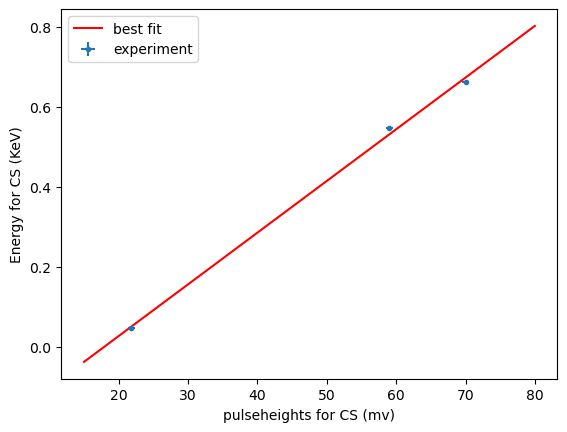

In [14]:
plt.errorbar(pulseheights_CS, energy_CS,  yerr = E_err_CS, xerr = P_err_list_CS, fmt = '.', label = 'experiment')
plt.plot(P_fit_CS, E_fit_CS, label = 'best fit', color = 'red')
plt.xlabel("pulseheights for CS (mv)")
plt.ylabel("Energy for CS (KeV)")
plt.legend(loc = 'upper left')
plt.show()

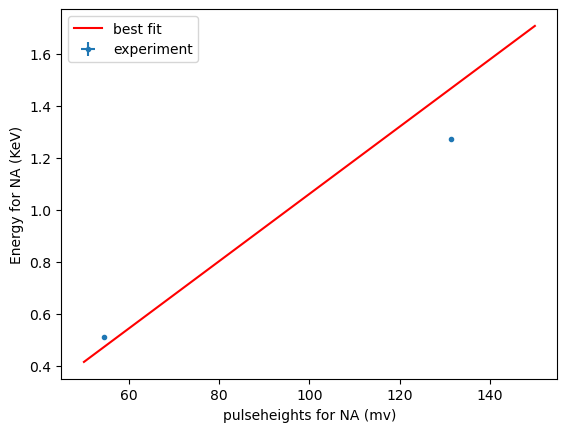

In [15]:
plt.errorbar(pulseheights_NA, energy_NA,  yerr = E_err_NA, xerr = P_err_list_NA, fmt = '.', label = 'experiment')
plt.plot(P_fit_NA, E_fit_NA, label = 'best fit', color = 'red')
plt.xlabel("pulseheights for NA (mv)")
plt.ylabel("Energy for NA (KeV)")
plt.legend(loc = 'upper left')
plt.show()

determine FWHM

In [16]:
x_data = []
y_data = []
counter = 0

pulseheights = []
counts = []
data_set = []

# transfer measured data to lists
with open("spectrum.csv", "r") as input_bestand:
    for regel in input_bestand:
        counter += 1
        if counter > 1:
            data_split = regel.split(',')
            data_set.append(data_split)
            pulseheights.append(float(data_split[0]))
            counts.append(float(data_split[1]))


adjust data to only look at biggest peak

In [17]:
for i, j in zip(pulseheights, counts):
    if i > 24 and i < 32:
        x_data.append(i)
        y_data.append(j)

define gaussian function to fit highest peak

In [18]:
def gaussian(x, A, sigma, mu):
    return A*np.exp(-(x-mu)**2 / (2*sigma**2))

In [19]:
# fit parameters with errors
model = curve_fit(gaussian, x_data, y_data, p0=[700, 2, 30])
A, sigma, mu = model[0]
A_err, sigma_err, mu_err = model[1][0]
print(A, sigma, mu)
print(A_err, sigma_err, mu_err)


2874.968569661472 1.0644179123454076 28.38974062464877
243.315532623588 -0.060063847372383246 -3.050955288811851e-06


In [20]:
y_gauss = []
x_gauss = []

In [21]:
# apply fit parameters to gaussian function
for x in np.arange(0, 100, 0.1):
    
    y = gaussian(x, A, sigma, mu)
    y_gauss.append(y)
    x_gauss.append(x)

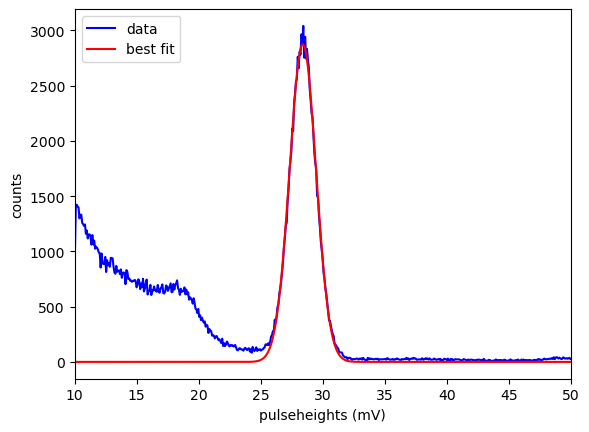

1999


In [22]:
plt.plot(pulseheights, counts, label = 'data', color = 'blue')
plt.plot(x_gauss, y_gauss, label = 'best fit', color = 'red')
plt.xlabel('pulseheights (mV)')
plt.ylabel('counts')
plt.legend(loc = 'upper left')
plt.xlim(10, 50)
plt.show()
print(len(pulseheights))

calculate FWHM

In [23]:
FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
FWHM_error = 2 * np.sqrt(2 * np.log(2)) * sigma_err

print(FWHM)
print(FWHM_error)

2.506512636280962
-0.1414395517741676


values for activity calculation

In [24]:
N_m = sum(counts) #N_measured
N_peak = sum(y_data) #N corresponding to how many counts in highest peak
A_0 = 382 * 10 ** 3 #start activity
t_half = 951441120 #half life (s)
lambda_value = np.log(2) / t_half
t = 600 #time of measurement (s)
t_2 = 439516800 #time (s) since production of source
r = 3 # radius of detector (cm)
R = 21.8 # distance from source to detector (cm)
E_p = N_peak / N_m #peak efficiency
E_g = (r ** 2) / (4 * R ** 2) #geometrical efficiency
E_d = 0.2 #detector efficiency (found in documentation)

print(N_m, N_peak, E_p, E_g)


234521.0 106040.0 0.45215567049432676 0.0047344499621244


calculate activity

In [25]:

A = N_m / (E_p * E_g * E_d * t) # our calculated activity
A_2 = A_0 * np.exp(-lambda_value * t_2) # real activity

print(f"A = {round(A)} Bq")
print(f"A_2 = {round(A_2)} Bq")

print(round(A / A_2, 2))


A = 912942 Bq
A_2 = 277334 Bq
3.29
